<a href="https://colab.research.google.com/gist/SravaniVelagapudi/b2c6a21f8949f261ddef07ae0c055a90/sravani-borra-recommendation-system-cornac-ctr-and-sorec-on-epinions-and-movielens-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cornac

     |████████████████████████████████| 12.4 MB 5.2 MB/s 


In [ ]:
import cornac
from cornac.data import TextModality, GraphModality
from cornac.eval_methods import RatioSplit, CrossValidation
from cornac.experiment import Experiment
from cornac import metrics
from cornac.models import SoRec, PMF, CTR, WMF
from cornac.models import SoRec, PMF
from cornac.data import Reader
from cornac.data.text import BaseTokenizer

from scipy.io import loadmat
import pandas as pd
from itertools import product

import itertools
import os
import sys
from collections import defaultdict

%tensorflow_version 1.x
import tensorflow as tf

from scipy import stats
import numpy as np

import random

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

SEED = 42
VERBOSE = True

TensorFlow 1.x selected.


In [ ]:
!apt install msttcorefonts -qq
!rm ~/.cache/matplotlib -rf

## Social Recommendation using PMF (SoRec)

SoRec leverages social relationships among users (e.g., trust), it jointly factorizes the user-item and user-user matrices

In [ ]:
# !wget -q --show-progress https://snap.stanford.edu/data/soc-Epinions1.txt.gz
# !gunzip soc-Epinions1.txt.gz
# https://www.cse.msu.edu/~tangjili/datasetcode/truststudy.htm
# https://github.com/JiaWu-Repository/STNE/blob/master/input/Epinions.txt
# http://www.trustlet.org/extended_epinions.html
# http://www.trustlet.org/downloaded_epinions.html
# https://github.com/parthpatel002/Social_Collaborative_Filtering_by_Trust/tree/master/data
# https://www.cse.msu.edu/~tangjili/trust.html

!wget -q --show-progress http://www.cse.msu.edu/~tangjili/datasetcode/epinions.zip
!unzip epinions.zip
!wget -q --show-progress http://www.cse.msu.edu/~tangjili/datasetcode/catalog_epinion.txt

epinions.zip        100%[===================>]   3.88M  1.88MB/s    in 2.1s    
Archive:  epinions.zip
   creating: epinions/
  inflating: epinions/rating.mat     
  inflating: epinions/trustnetwork.mat  
catalog_epinion.txt 100%[===================>]     505  --.-KB/s    in 0s      


In [ ]:
epinions_rating = loadmat('epinions/rating.mat')['rating']
epinions_rating

array([[    1,     1,     3,     2],
       [    1,     2,     2,     2],
       [    1,     3,     3,     2],
       ...,
       [22166, 43538,     5,     5],
       [22166, 38711,     3,     4],
       [22166, 41790,     5,     3]], dtype=int32)

In [ ]:
epinions_rating = pd.DataFrame(epinions_rating,
                               columns=['userid', 'productid', 'categoryid', 'rating'])
epinions_rating = epinions_rating.astype('str')
epinions_rating = epinions_rating[['userid', 'productid', 'rating']]
epinions_rating.head()

userid productid rating
0      1         1      2
1      1         2      2
2      1         3      2
3      1         4      5
4      1         5      3

In [ ]:
epinions_rating.describe()

userid productid  rating
count   922267    922267  922267
unique   22164    296277       5
top       6877       122       5
freq      5357      1834  389778

In [ ]:
density = len(epinions_rating) / (epinions_rating.userid.nunique() * epinions_rating.productid.nunique())
sparsity = 1 - density
print('Sparsity of the data is {:.4%}'.format(sparsity))

Sparsity of the data is 99.9860%


In [ ]:
def remove_cat_outliers(df, col, sd=3):
    x = df[col].value_counts()
    valid_ids = list(set(x[(np.abs(stats.zscore(x)) < sd)].index.tolist()))
    valid_ids = [str(x) for x in valid_ids]
    df = df[df[col].isin(valid_ids)]
    return df

In [ ]:
epinions_rating = remove_cat_outliers(epinions_rating, col='userid')
epinions_rating = remove_cat_outliers(epinions_rating, col='productid')
epinions_rating.describe()

userid productid  rating
count   521029    521029  521029
unique   21862    203188       5
top       8690     18584       5
freq       371        45  231118

The code in the below cell is for data sampling. Here, we are randomly picking only few users so that multiple models can be trained faster. For full data training, comment/skip this code.

In [ ]:
random_user_ids = random.sample(list(epinions_rating['userid'].unique()), 1000)
epinions_rating = epinions_rating[epinions_rating['userid'].isin(random_user_ids)]
epinions_rating.describe()

userid productid rating
count   25347     25347  25347
unique   1000     21500      5
top     12568      2533      5
freq      362         8  11524

In [ ]:
density = len(epinions_rating) / (epinions_rating.userid.nunique() * epinions_rating.productid.nunique())
sparsity = 1 - density
print('Sparsity of the data is {:.4%}'.format(sparsity))

Sparsity of the data is 99.8821%


In [ ]:
epinions_rating_data = [tuple(x) for x in epinions_rating.to_numpy()]
epinions_rating_data[:5]

[('8', '130', '5'),
 ('8', '131', '4'),
 ('8', '132', '1'),
 ('8', '133', '4'),
 ('8', '134', '4')]

In [ ]:
epinions_trust = loadmat('epinions/trustnetwork.mat')['trustnetwork']
epinions_trust

array([[15373,  9831],
       [ 4247,  9831],
       [ 4644,  9831],
       ...,
       [13181, 15645],
       [  897,  8000],
       [ 8000,   897]], dtype=uint16)

In [ ]:
epinions_trust = pd.DataFrame(epinions_trust,
                               columns=['user1', 'user2'])
epinions_trust['weight'] = 1
epinions_trust = epinions_trust.astype('str')
epinions_trust.head()

user1 user2 weight
0  15373  9831      1
1   4247  9831      1
2   4644  9831      1
3   6823  9831      1
4   7479  9831      1

In [ ]:
epinions_trust.describe()

user1   user2  weight
count   355754  355754  355754
unique   15451   15892       1
top      14547   16242       1
freq      1551    2023  355754

In [ ]:
epinions_trust = epinions_trust[epinions_trust['user1'].isin(epinions_rating.userid.unique())]
epinions_trust = epinions_trust[epinions_trust['user2'].isin(epinions_rating.userid.unique())]
epinions_trust.describe()

user1  user2 weight
count    808    808    808
unique   301    213      1
top     5670  16242      1
freq      29     88    808

In [ ]:
epinions_trust_data = [tuple(x) for x in epinions_trust.to_numpy()]
epinions_trust_data[:5]

[('4644', '9831', '1'),
 ('16058', '9831', '1'),
 ('12109', '9831', '1'),
 ('8217', '9831', '1'),
 ('10179', '9831', '1')]

In [ ]:
# Instantiate a GraphModality, it makes it convenient to work with graph (network) auxiliary information
user_graph_modality = GraphModality(data=epinions_trust_data)

# Define an evaluation method to split feedback into train and test sets
eval_method = CrossValidation(
    data=epinions_rating_data,
    n_folds=5,
    rating_threshold=2.5,
    exclude_unknowns=True,
    verbose=True,
    user_graph=user_graph_modality,
    seed=123,
)

# Instantiate SoRec model
K = 20
sorec = SoRec(k=K, max_iter=50, learning_rate=0.001, verbose=VERBOSE, seed=SEED)
pmf = PMF(k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED)

# Evaluation metrics
rmse = metrics.RMSE()
mae = metrics.MAE()

# Put everything together into an experiment and run it
Experiment(
    eval_method=eval_method, models=[sorec, pmf], metrics=[rmse, mae]
).run()

rating_threshold = 2.5
exclude_unknowns = True
Fold: 1
---
Training data:
Number of users = 999
Number of items = 17687
Number of ratings = 20171
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 536
Number of items = 1055
Number of ratings = 1153
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 536
Number of items = 1055
Number of ratings = 1153
---
Total users = 999
Total items = 17687

[SoRec] Training started!
Learning...
epoch 0, loss: 3126.138894
epoch 1, loss: 3082.573593
epoch 2, loss: 3041.675362
epoch 3, loss: 2999.996326
epoch 4, loss: 2951.978091
epoch 5, loss: 2897.852398
epoch 6, loss: 2839.132349
epoch 7, loss: 2777.312323
epoch 8, loss: 2713.776471
epoch 9, loss: 2649.622238
epoch 10, loss: 2585.720169
epoch 11, loss: 2522.626047
epoch 12, loss: 2460.752381
epoch 13, loss: 2400.242135
epoch 14, loss: 2341.242317
epoch 15, loss: 2283.799404
epoch 16, loss: 2227.966546
epoch 17, loss: 2173.75

Rating:   0%|          | 0/1153 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 1000
Number of items = 17646
Number of ratings = 20157
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 561
Number of items = 1036
Number of ratings = 1125
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 561
Number of items = 1036
Number of ratings = 1125
---
Total users = 1000
Total items = 17646

[SoRec] Training started!
Learning...
epoch 0, loss: 3125.318003
epoch 1, loss: 3081.569197
epoch 2, loss: 3041.490771
epoch 3, loss: 3000.687774
epoch 4, loss: 2953.476362
epoch 5, loss: 2900.024540
epoch 6, loss: 2841.802124
epoch 7, loss: 2780.168411
epoch 8, loss: 2716.582984
epoch 9, loss: 2652.257216
epoch 10, loss: 2588.256416
epoch 11, loss: 2525.072493
epoch 12, loss: 2463.084958
epoch 13, loss: 2402.452275
epoch 14, loss: 2343.319426
epoch 15, loss: 2285.752990
epoch 16, loss: 2229.797811
epoch 17, loss: 2175.495024
epoch 18, loss: 2122.836175
epoch 19, lo

Rating:   0%|          | 0/1125 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 998
Number of items = 17690
Number of ratings = 20165
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 550
Number of items = 1067
Number of ratings = 1156
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 550
Number of items = 1067
Number of ratings = 1156
---
Total users = 998
Total items = 17690

[SoRec] Training started!
Learning...
epoch 0, loss: 3144.884411
epoch 1, loss: 3100.943160
epoch 2, loss: 3060.140142
epoch 3, loss: 3018.412032
epoch 4, loss: 2970.162002
epoch 5, loss: 2915.635562
epoch 6, loss: 2856.489900
epoch 7, loss: 2794.106173
epoch 8, loss: 2729.846226
epoch 9, loss: 2664.857991
epoch 10, loss: 2600.230606
epoch 11, loss: 2536.532676
epoch 12, loss: 2474.088842
epoch 13, loss: 2413.057811
epoch 14, loss: 2353.560717
epoch 15, loss: 2295.674597
epoch 16, loss: 2239.423151
epoch 17, loss: 2184.846701
epoch 18, loss: 2131.934574
epoch 19, loss

Rating:   0%|          | 0/1156 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 998
Number of items = 17682
Number of ratings = 20176
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 557
Number of items = 1063
Number of ratings = 1159
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 557
Number of items = 1063
Number of ratings = 1159
---
Total users = 998
Total items = 17682

[SoRec] Training started!
Learning...
epoch 0, loss: 3136.691752
epoch 1, loss: 3092.897322
epoch 2, loss: 3052.643726
epoch 3, loss: 3011.539137
epoch 4, loss: 2963.838158
epoch 5, loss: 2909.756814
epoch 6, loss: 2850.819452
epoch 7, loss: 2788.439734
epoch 8, loss: 2724.056630
epoch 9, loss: 2658.917577
epoch 10, loss: 2594.010102
epoch 11, loss: 2529.905285
epoch 12, loss: 2467.032952
epoch 13, loss: 2405.628617
epoch 14, loss: 2345.827763
epoch 15, loss: 2287.704006
epoch 16, loss: 2231.273450
epoch 17, loss: 2176.574032
epoch 18, loss: 2123.606588
epoch 19, loss

Rating:   0%|          | 0/1159 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 997
Number of items = 17729
Number of ratings = 20180
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 575
Number of items = 1104
Number of ratings = 1200
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 575
Number of items = 1104
Number of ratings = 1200
---
Total users = 997
Total items = 17729

[SoRec] Training started!
Learning...
epoch 0, loss: 3135.894682
epoch 1, loss: 3092.720800
epoch 2, loss: 3051.781620
epoch 3, loss: 3009.795459
epoch 4, loss: 2961.189090
epoch 5, loss: 2906.366355
epoch 6, loss: 2846.915946
epoch 7, loss: 2784.387079
epoch 8, loss: 2720.166988
epoch 9, loss: 2655.354216
epoch 10, loss: 2590.841705
epoch 11, loss: 2527.163859
epoch 12, loss: 2464.742466
epoch 13, loss: 2403.717123
epoch 14, loss: 2344.244102
epoch 15, loss: 2286.367976
epoch 16, loss: 2230.153534
epoch 17, loss: 2175.593745
epoch 18, loss: 2122.737718
epoch 19, loss

Rating:   0%|          | 0/1200 [00:00<?, ?it/s]

Fold: 1
---
Training data:
Number of users = 999
Number of items = 17687
Number of ratings = 20171
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 536
Number of items = 1055
Number of ratings = 1153
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 536
Number of items = 1055
Number of ratings = 1153
---
Total users = 999
Total items = 17687

[PMF] Training started!
Learning...
epoch 0, loss: 3042.152274
epoch 1, loss: 3041.401902
epoch 2, loss: 3038.331738
epoch 3, loss: 3032.498040
epoch 4, loss: 3023.883333
epoch 5, loss: 3012.815367
epoch 6, loss: 2999.696307
epoch 7, loss: 2984.888400
epoch 8, loss: 2968.688852
epoch 9, loss: 2951.335858
epoch 10, loss: 2933.018570
epoch 11, loss: 2913.889919
epoch 12, loss: 2894.075978
epoch 13, loss: 2873.683446
epoch 14, loss: 2852.804377
epoch 15, loss: 2831.518579
epoch 16, loss: 2809.895867
epoch 17, loss: 2787.997997
epoch 18, loss: 2765.879870
epoch 19, loss: 

Rating:   0%|          | 0/1153 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 1000
Number of items = 17646
Number of ratings = 20157
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 561
Number of items = 1036
Number of ratings = 1125
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 561
Number of items = 1036
Number of ratings = 1125
---
Total users = 1000
Total items = 17646

[PMF] Training started!
Learning...
epoch 0, loss: 3041.588955
epoch 1, loss: 3040.833884
epoch 2, loss: 3037.738972
epoch 3, loss: 3031.857236
epoch 4, loss: 3023.183940
epoch 5, loss: 3012.044932
epoch 6, loss: 2998.824829
epoch 7, loss: 2983.878962
epoch 8, loss: 2967.505649
epoch 9, loss: 2949.952932
epoch 10, loss: 2931.424009
epoch 11, loss: 2912.083317
epoch 12, loss: 2892.065851
epoch 13, loss: 2871.483843
epoch 14, loss: 2850.431277
epoch 15, loss: 2828.987728
epoch 16, loss: 2807.222259
epoch 17, loss: 2785.195667
epoch 18, loss: 2762.961666
epoch 19, loss

Rating:   0%|          | 0/1125 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 998
Number of items = 17690
Number of ratings = 20165
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 550
Number of items = 1067
Number of ratings = 1156
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 550
Number of items = 1067
Number of ratings = 1156
---
Total users = 998
Total items = 17690

[PMF] Training started!
Learning...
epoch 0, loss: 3061.401691
epoch 1, loss: 3060.623067
epoch 2, loss: 3057.458461
epoch 3, loss: 3051.452682
epoch 4, loss: 3042.609727
epoch 5, loss: 3031.294234
epoch 6, loss: 3017.915748
epoch 7, loss: 3002.833597
epoch 8, loss: 2986.340111
epoch 9, loss: 2968.675697
epoch 10, loss: 2950.038477
epoch 11, loss: 2930.591706
epoch 12, loss: 2910.469818
epoch 13, loss: 2889.784377
epoch 14, loss: 2868.629091
epoch 15, loss: 2847.083104
epoch 16, loss: 2825.214140
epoch 17, loss: 2803.081227
epoch 18, loss: 2780.736316
epoch 19, loss: 

Rating:   0%|          | 0/1156 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 998
Number of items = 17682
Number of ratings = 20176
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 557
Number of items = 1063
Number of ratings = 1159
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 557
Number of items = 1063
Number of ratings = 1159
---
Total users = 998
Total items = 17682

[PMF] Training started!
Learning...
epoch 0, loss: 3052.901838
epoch 1, loss: 3052.128796
epoch 2, loss: 3048.980033
epoch 3, loss: 3043.023825
epoch 4, loss: 3034.263441
epoch 5, loss: 3023.037247
epoch 6, loss: 3009.736395
epoch 7, loss: 2994.709618
epoch 8, loss: 2978.249847
epoch 9, loss: 2960.601121
epoch 10, loss: 2941.965241
epoch 11, loss: 2922.509076
epoch 12, loss: 2902.370158
epoch 13, loss: 2881.662847
epoch 14, loss: 2860.483102
epoch 15, loss: 2838.912026
epoch 16, loss: 2817.019440
epoch 17, loss: 2794.866527
epoch 18, loss: 2772.507166
epoch 19, loss: 

Rating:   0%|          | 0/1159 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 997
Number of items = 17729
Number of ratings = 20180
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 575
Number of items = 1104
Number of ratings = 1200
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 575
Number of items = 1104
Number of ratings = 1200
---
Total users = 997
Total items = 17729

[PMF] Training started!
Learning...
epoch 0, loss: 3051.838980
epoch 1, loss: 3051.060388
epoch 2, loss: 3047.869687
epoch 3, loss: 3041.809870
epoch 4, loss: 3032.900477
epoch 5, loss: 3021.509104
epoch 6, loss: 3008.038134
epoch 7, loss: 2992.848335
epoch 8, loss: 2976.247579
epoch 9, loss: 2958.485997
epoch 10, loss: 2939.764569
epoch 11, loss: 2920.245640
epoch 12, loss: 2900.061773
epoch 13, loss: 2879.323347
epoch 14, loss: 2858.123601
epoch 15, loss: 2836.541737
epoch 16, loss: 2814.646355
epoch 17, loss: 2792.497519
epoch 18, loss: 2770.147948
epoch 19, loss: 

Rating:   0%|          | 0/1200 [00:00<?, ?it/s]


TEST:
...
[SoRec]
       |    MAE |   RMSE | Train (s) | Test (s)
------ + ------ + ------ + --------- + --------
Fold 0 | 1.3339 | 1.3828 |    1.0881 |   0.2488
Fold 1 | 1.3310 | 1.3806 |    1.0873 |   0.3222
Fold 2 | 1.3164 | 1.3685 |    1.1088 |   0.2453
Fold 3 | 1.3841 | 1.4343 |    1.0864 |   0.3469
Fold 4 | 1.3622 | 1.4101 |    1.0627 |   0.3015
------ + ------ + ------ + --------- + --------
Mean   | 1.3455 | 1.3953 |    1.0867 |   0.2929
Std    | 0.0243 | 0.0238 |    0.0146 |   0.0401

[PMF]
       |    MAE |   RMSE | Train (s) | Test (s)
------ + ------ + ------ + --------- + --------
Fold 0 | 1.3781 | 1.4251 |    1.0030 |   0.3152
Fold 1 | 1.3985 | 1.4450 |    0.9718 |   0.2642
Fold 2 | 1.3660 | 1.4145 |    0.9738 |   0.3225
Fold 3 | 1.4338 | 1.4803 |    1.0107 |   0.2543
Fold 4 | 1.4116 | 1.4582 |    0.9755 |   0.3488
------ + ------ + ------ + --------- + --------
Mean   | 1.3976 | 1.4446 |    0.9870 |   0.3010
Std    | 0.0240 | 0.0234 |    0.0165 |   0.0360



In [ ]:
# Instantiate a GraphModality, it makes it convenient to work with graph (network) auxiliary information
user_graph_modality = GraphModality(data=epinions_trust_data)

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=epinions_rating_data,
    test_size=0.2,
    rating_threshold=2.5,
    exclude_unknowns=True,
    verbose=True,
    user_graph=user_graph_modality,
    seed=123,
)

# Instantiate SoRec model
K = 20
sorec = SoRec(k=K, max_iter=50, learning_rate=0.001, verbose=VERBOSE, seed=SEED)
pmf = PMF(k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED)

# Evaluation metrics
rmse = metrics.RMSE()
mae = metrics.MAE()

# Put everything together into an experiment and run it
Experiment(
    eval_method=ratio_split, models=[sorec, pmf], metrics=[rmse, mae]
).run()

rating_threshold = 2.5
exclude_unknowns = True
---
Training data:
Number of users = 999
Number of items = 17715
Number of ratings = 20172
Max rating = 5.0
Min rating = 1.0
Global mean = 4.1
---
Test data:
Number of users = 560
Number of items = 1084
Number of ratings = 1178
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 999
Total items = 17715

[SoRec] Training started!
Learning...
epoch 0, loss: 3135.530126
epoch 1, loss: 3092.659866
epoch 2, loss: 3051.578115
epoch 3, loss: 3009.768502
epoch 4, loss: 2961.640450
epoch 5, loss: 2907.363758
epoch 6, loss: 2848.573106
epoch 7, loss: 2786.743848
epoch 8, loss: 2723.225201
epoch 9, loss: 2659.060304
epoch 10, loss: 2595.175323
epoch 11, loss: 2532.107932
epoch 12, loss: 2470.285451
epoch 13, loss: 2409.894040
epoch 14, loss: 2351.048042
epoch 15, loss: 2293.789664
epoch 16, loss: 2238.157139
epoch 17, loss: 2184.147993
epoch 18, loss: 2131.822053
epoch 19, loss: 2081.139300
epoch 20, loss: 2032.028517
epoch 21, 

Rating:   0%|          | 0/1178 [00:00<?, ?it/s]


[PMF] Training started!
Learning...
epoch 0, loss: 3051.277013
epoch 1, loss: 3050.527843
epoch 2, loss: 3047.460972
epoch 3, loss: 3041.589401
epoch 4, loss: 3032.876150
epoch 5, loss: 3021.661374
epoch 6, loss: 3008.358446
epoch 7, loss: 2993.329899
epoch 8, loss: 2976.878542
epoch 9, loss: 2959.253386
epoch 10, loss: 2940.655258
epoch 11, loss: 2921.245996
epoch 12, loss: 2901.158600
epoch 13, loss: 2880.504093
epoch 14, loss: 2859.377528
epoch 15, loss: 2837.860573
epoch 16, loss: 2816.023346
epoch 17, loss: 2793.926642
epoch 18, loss: 2771.623838
epoch 19, loss: 2749.162247
epoch 20, loss: 2726.583963
epoch 21, loss: 2703.926475
epoch 22, loss: 2681.223313
epoch 23, loss: 2658.504645
epoch 24, loss: 2635.797854
epoch 25, loss: 2613.128011
epoch 26, loss: 2590.518103
epoch 27, loss: 2567.989127
epoch 28, loss: 2545.560219
epoch 29, loss: 2523.248751
epoch 30, loss: 2501.070521
epoch 31, loss: 2479.039860
epoch 32, loss: 2457.169737
epoch 33, loss: 2435.471938
epoch 34, loss: 2413.

Rating:   0%|          | 0/1178 [00:00<?, ?it/s]


TEST:
...
      |    MAE |   RMSE | Train (s) | Test (s)
----- + ------ + ------ + --------- + --------
SoRec | 1.3572 | 1.4049 |    1.1442 |   0.2453
PMF   | 1.4014 | 1.4499 |    1.0349 |   0.2676



In [ ]:
sorec.U

array([[-1.28443168,  1.33576457, -1.29374345, ..., -1.34199778,
         1.32994598, -1.30524596],
       [ 0.52334958,  0.50661687, -0.52579348, ..., -0.52927364,
        -0.52895522,  0.52975819],
       [ 0.46491122,  0.92359987, -0.68037205, ..., -1.12994399,
        -1.13397686,  0.79099978],
       ...,
       [ 0.12001574, -0.05381177, -0.1217517 , ..., -0.11352717,
        -0.11927219, -0.04682065],
       [ 0.07316766,  0.07042394,  0.07448959, ...,  0.07132035,
         0.07603002, -0.07363325],
       [ 0.07600199,  0.07492945, -0.07782244, ..., -0.07633327,
        -0.07450179,  0.07593235]])

Below is the variance of each user latent dimension.

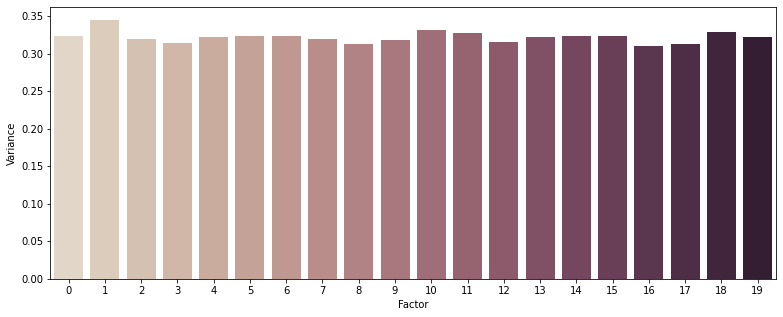

In [ ]:
# variance of each user latent dimension

var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(sorec.U, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

Let's select two dimensions and see how users are distributed in that 2D space. In addition, we can visualize connections between two users if they are linked in the social network.

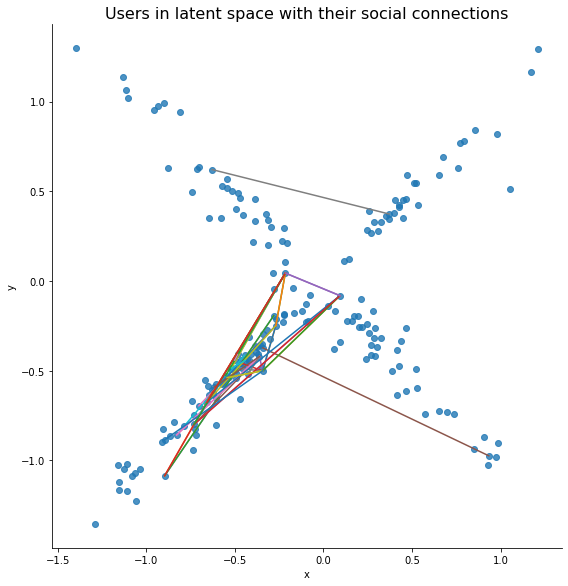

In [ ]:
TOP2F = (2, 7)
SAMPLE_SIZE = 200

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(sorec.U.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=sorec.U[sample_inds][:, TOP2F], columns=["x", "y"])

g = sns.lmplot(x="x", y="y", data=sample_df, height=8.0, fit_reg=False)
g.ax.set_title("Users in latent space with their social connections", fontsize=16)

adj_mat = sorec.train_set.user_graph.matrix
for i in range(len(sample_inds)):
  for j in range(len(sample_inds)):
    if j != i and adj_mat[sample_inds[i], sample_inds[j]]:
      sns.lineplot(x="x", y="y", data=sample_df.loc[[i, j]])

There are indeed some locality of user connections shown in the figure above. That suggests social network information is captured in the user latent factors and has some influence on the recommendations by the SoRec model.

### Grid

In [ ]:
class CustomExperiment(Experiment):
    def run(self):
        """Run the Cornac experiment"""
        self._create_result()

        for model in self.models:
            test_result, val_result = self.eval_method.evaluate(
                model=model,
                metrics=self.metrics,
                user_based=self.user_based,
                show_validation=self.show_validation,
            )

            self.result.append(test_result)

In [ ]:
def experiment(row,
               epinions_rating=None,
               epinions_trust=None):
    
    VERBOSE = False
    test_size = row.test_size
    K = row.K
    rating_threshold = row.rating_threshold
    learning_rate = row.learning_rate
    lambda_reg = row.lambda_reg
    lambda_c = row.lambda_c
    user_based = row.user_based
    model = row.model
    # sample_size = row.sample_size

    # if sample_size is not None:
    #     epinions_rating = epinions_rating.sample(n=int(sample_size))
    #     epinions_trust = epinions_trust[epinions_trust['user1'].isin(epinions_rating.userid.unique())]
    #     epinions_trust = epinions_trust[epinions_trust['user2'].isin(epinions_rating.userid.unique())]
    
    # epinions_rating_data = [tuple(x) for x in epinions_rating.to_numpy()]
    # epinions_trust_data = [tuple(x) for x in epinions_trust.to_numpy()]
    
    # user_graph_modality = GraphModality(data=epinions_trust_data)

    # Define an evaluation method to split feedback into train and test sets
    ratio_split = RatioSplit(
        data=epinions_rating_data,
        test_size=test_size,
        rating_threshold=rating_threshold,
        exclude_unknowns=True,
        verbose=VERBOSE,
        user_graph=user_graph_modality,
        seed=SEED
    )

    if model == 'sorec':
        model = SoRec(k=K, max_iter=50, learning_rate=learning_rate, lambda_c=lambda_c, verbose=VERBOSE, seed=SEED)
    elif model == 'pmf':
        model = PMF(k=K, max_iter=50, learning_rate=learning_rate, lambda_reg=lambda_reg, verbose=VERBOSE, seed=SEED)

    exp = CustomExperiment(eval_method=ratio_split, models=[model], metrics=[mae], user_based=user_based,
                     verbose=VERBOSE, save_dir=None)
    _ = exp.run()

    row = row.append(pd.Series(dict(exp.result[0].metric_avg_results)))

    return row

In [ ]:
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks", {'axes.grid' : False})

rc = {'figure.figsize':(10, 5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Times New Roman',
      'font.size' : 15}
plt.rcParams.update(rc)

### Exp 1

In [ ]:
# grid
# test_size = [0.01, 0.2, 0.5, 0.8]
# K = [5, 10]
# rating_threshold = [2.5]
# learning_rate = [0.001]
# lambda_reg = [0.01]
# lambda_c = [5,10,15,20,50,100]
# sample_size = [None] # takes full data if none
# user_based = [True]
# model = ['sorec','pmf']

test_size = [0.01, 0.2, 0.5, 0.8]
K = [20]
rating_threshold = [2.5]
learning_rate = [0.001]
lambda_reg = [0.01]
lambda_c = [5,10,15,20,50,100]
sample_size = [None] # takes full data if none
user_based = [True]
model = ['sorec']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_reg, lambda_c,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_reg',
                                 'lambda_c',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size   K  rating_threshold  learning_rate  lambda_reg  lambda_c  \
0        0.01  20               2.5          0.001        0.01         5   
1        0.01  20               2.5          0.001        0.01        10   
2        0.01  20               2.5          0.001        0.01        15   
3        0.01  20               2.5          0.001        0.01        20   
4        0.01  20               2.5          0.001        0.01        50   
5        0.01  20               2.5          0.001        0.01       100   
6        0.20  20               2.5          0.001        0.01         5   
7        0.20  20               2.5          0.001        0.01        10   
8        0.20  20               2.5          0.001        0.01        15   
9        0.20  20               2.5          0.001        0.01        20   
10       0.20  20               2.5          0.001        0.01        50   
11       0.20  20               2.5          0.001        0.01       100   
12       0.50  20               2.5          0.001        0.01         5   
13       0.50  20               2.5          0.001        0.01        10   
14       0.50  20               2.5          0.001        0.01        15   
15       0.50  20               2.5          0.001        0.01        20   
16       0.50  20               2.5          0.001        0.01        50   
17       0.50  20               2.5          0.001        0.01       100   
18       0.80  20               2.5          0.001        0.01         5   
19       0.80  20               2.5          0.001        0.01        10   
20       0.80  20               2.5          0.001        0.01        15   
21       0.80  20               2.5          0.001        0.01        20   
22       0.80  20               2.5          0.001        0.01        50   
23       0.80  20               2.5          0.001        0.01       100   

    user_based  model sample_size  
0         True  sorec        None  
1         True  sorec        None  
2         True  sorec        None  
3         True  sorec        None  
4         True  sorec        None  
5         True  sorec        None  
6         True  sorec        None  
7         True  sorec        None  
8         True  sorec        None  
9         True  sorec        None  
10        True  sorec        None  
11        True  sorec        None  
12        True  sorec        None  
13        True  sorec        None  
14        True  sorec        None  
15        True  sorec        None  
16        True  sorec        None  
17        True  sorec        None  
18        True  sorec        None  
19        True  sorec        None  
20        True  sorec        None  
21        True  sorec        None  
22        True  sorec        None  
23        True  sorec        None

In [ ]:
results1 = params.progress_apply(experiment, axis=1)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
results1.head()

test_size   K  rating_threshold  learning_rate  lambda_reg  lambda_c  \
0       0.01  20               2.5          0.001        0.01         5   
1       0.01  20               2.5          0.001        0.01        10   
2       0.01  20               2.5          0.001        0.01        15   
3       0.01  20               2.5          0.001        0.01        20   
4       0.01  20               2.5          0.001        0.01        50   

   user_based  model sample_size       MAE  Train (s)  Test (s)  
0        True  sorec        None  1.367670   1.301025  0.016638  
1        True  sorec        None  1.372035   1.272793  0.017809  
2        True  sorec        None  1.368707   1.281379  0.015633  
3        True  sorec        None  1.371704   2.097109  0.019526  
4        True  sorec        None  1.376599   2.355680  0.016571

In [ ]:
data = results1[['test_size', 'lambda_c', 'MAE']]
data['test_size'] = data.apply(lambda row: 'SoRec {:.0%} as Testing data'.format(row.test_size), axis=1)
data = data.rename(columns={'test_size':'Model & Testing size'})
data

Model & Testing size  lambda_c       MAE
0    SoRec 1% as Testing data         5  1.367670
1    SoRec 1% as Testing data        10  1.372035
2    SoRec 1% as Testing data        15  1.368707
3    SoRec 1% as Testing data        20  1.371704
4    SoRec 1% as Testing data        50  1.376599
5    SoRec 1% as Testing data       100  1.387880
6   SoRec 20% as Testing data         5  1.355693
7   SoRec 20% as Testing data        10  1.355499
8   SoRec 20% as Testing data        15  1.357234
9   SoRec 20% as Testing data        20  1.359948
10  SoRec 20% as Testing data        50  1.377236
11  SoRec 20% as Testing data       100  1.394295
12  SoRec 50% as Testing data         5  1.370195
13  SoRec 50% as Testing data        10  1.369381
14  SoRec 50% as Testing data        15  1.369959
15  SoRec 50% as Testing data        20  1.371296
16  SoRec 50% as Testing data        50  1.377359
17  SoRec 50% as Testing data       100  1.389975
18  SoRec 80% as Testing data         5  1.365308
19  SoRec 80% as Testing data        10  1.365459
20  SoRec 80% as Testing data        15  1.365163
21  SoRec 80% as Testing data        20  1.365359
22  SoRec 80% as Testing data        50  1.369430
23  SoRec 80% as Testing data       100  1.373135

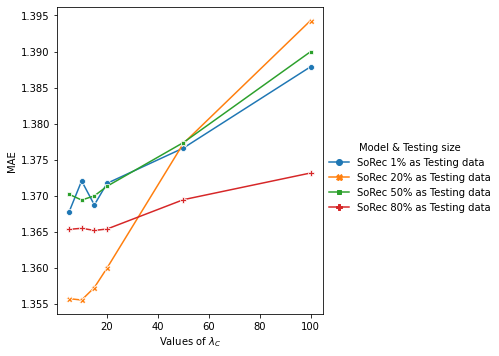

In [ ]:
g = sns.relplot(data=data, x='lambda_c', y='MAE',
                hue='Model & Testing size', style='Model & Testing size',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "Values of $\lambda_C$", ylabel = "MAE")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('SoRec_1_v2.svg', format='svg', dpi=1200)

### Exp 2

In [ ]:
test_size = [0.01, 0.2, 0.5, 0.8]
K = [5, 10, 20, 30, 50, 100]
rating_threshold = [2.5]
learning_rate = [0.001]
lambda_reg = [0.01]
lambda_c = [10]
sample_size = [None] # takes full data if none
user_based = [True]
model = ['sorec','pmf']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_reg, lambda_c,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_reg',
                                 'lambda_c',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size    K  rating_threshold  learning_rate  lambda_reg  lambda_c  \
0        0.01    5               2.5          0.001        0.01        10   
1        0.01    5               2.5          0.001        0.01        10   
2        0.01   10               2.5          0.001        0.01        10   
3        0.01   10               2.5          0.001        0.01        10   
4        0.01   20               2.5          0.001        0.01        10   
5        0.01   20               2.5          0.001        0.01        10   
6        0.01   30               2.5          0.001        0.01        10   
7        0.01   30               2.5          0.001        0.01        10   
8        0.01   50               2.5          0.001        0.01        10   
9        0.01   50               2.5          0.001        0.01        10   
10       0.01  100               2.5          0.001        0.01        10   
11       0.01  100               2.5          0.001        0.01        10   
12       0.20    5               2.5          0.001        0.01        10   
13       0.20    5               2.5          0.001        0.01        10   
14       0.20   10               2.5          0.001        0.01        10   
15       0.20   10               2.5          0.001        0.01        10   
16       0.20   20               2.5          0.001        0.01        10   
17       0.20   20               2.5          0.001        0.01        10   
18       0.20   30               2.5          0.001        0.01        10   
19       0.20   30               2.5          0.001        0.01        10   
20       0.20   50               2.5          0.001        0.01        10   
21       0.20   50               2.5          0.001        0.01        10   
22       0.20  100               2.5          0.001        0.01        10   
23       0.20  100               2.5          0.001        0.01        10   
24       0.50    5               2.5          0.001        0.01        10   
25       0.50    5               2.5          0.001        0.01        10   
26       0.50   10               2.5          0.001        0.01        10   
27       0.50   10               2.5          0.001        0.01        10   
28       0.50   20               2.5          0.001        0.01        10   
29       0.50   20               2.5          0.001        0.01        10   
30       0.50   30               2.5          0.001        0.01        10   
31       0.50   30               2.5          0.001        0.01        10   
32       0.50   50               2.5          0.001        0.01        10   
33       0.50   50               2.5          0.001        0.01        10   
34       0.50  100               2.5          0.001        0.01        10   
35       0.50  100               2.5          0.001        0.01        10   
36       0.80    5               2.5          0.001        0.01        10   
37       0.80    5               2.5          0.001        0.01        10   
38       0.80   10               2.5          0.001        0.01        10   
39       0.80   10               2.5          0.001        0.01        10   
40       0.80   20               2.5          0.001        0.01        10   
41       0.80   20               2.5          0.001        0.01        10   
42       0.80   30               2.5          0.001        0.01        10   
43       0.80   30               2.5          0.001        0.01        10   
44       0.80   50               2.5          0.001        0.01        10   
45       0.80   50               2.5          0.001        0.01        10   
46       0.80  100               2.5          0.001        0.01        10   
47       0.80  100               2.5          0.001        0.01        10   

    user_based  model sample_size  
0         True  sorec        None  
1         True    pmf        None  
2         True  sorec        None  
3         True    pmf        None  
4         True  sorec        None  
5         True

In [ ]:
results2 = params.progress_apply(experiment, axis=1)

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
results2.head()

test_size   K  rating_threshold  learning_rate  lambda_reg  lambda_c  \
0       0.01   5               2.5          0.001        0.01        10   
1       0.01   5               2.5          0.001        0.01        10   
2       0.01  10               2.5          0.001        0.01        10   
3       0.01  10               2.5          0.001        0.01        10   
4       0.01  20               2.5          0.001        0.01        10   

   user_based  model sample_size       MAE  Train (s)  Test (s)  
0        True  sorec        None  1.426679   0.324541  0.010531  
1        True    pmf        None  1.443764   0.306370  0.015013  
2        True  sorec        None  1.381091   0.616741  0.016399  
3        True    pmf        None  1.439559   0.578141  0.017622  
4        True  sorec        None  1.372035   1.279256  0.017057

In [ ]:
data = results2[['test_size', 'K', 'model', 'MAE']]
data['model'] = data['model'].replace({'sorec':'SoRec', 'pmf':'PMF'})
data['model_k'] = data.apply(lambda row: '{} @ K={}'.format(row.model, row.K), axis=1)
data.drop(['model','K'], axis=1, inplace=True)
data = data.rename(columns={'model_k':'Model & Dimensionality',
                            'test_size':'Testing Data'})
data

Testing Data       MAE Model & Dimensionality
0           0.01  1.426679            SoRec @ K=5
1           0.01  1.443764              PMF @ K=5
2           0.01  1.381091           SoRec @ K=10
3           0.01  1.439559             PMF @ K=10
4           0.01  1.372035           SoRec @ K=20
5           0.01  1.451249             PMF @ K=20
6           0.01  1.359980           SoRec @ K=30
7           0.01  1.410836             PMF @ K=30
8           0.01  1.309368           SoRec @ K=50
9           0.01  1.441169             PMF @ K=50
10          0.01  1.329503          SoRec @ K=100
11          0.01  1.408680            PMF @ K=100
12          0.20  1.387126            SoRec @ K=5
13          0.20  1.425728              PMF @ K=5
14          0.20  1.375634           SoRec @ K=10
15          0.20  1.429096             PMF @ K=10
16          0.20  1.355499           SoRec @ K=20
17          0.20  1.420040             PMF @ K=20
18          0.20  1.358253           SoRec @ K=30
19          0.20  1.412558             PMF @ K=30
20          0.20  1.332139           SoRec @ K=50
21          0.20  1.405005             PMF @ K=50
22          0.20  1.305290          SoRec @ K=100
23          0.20  1.400842            PMF @ K=100
24          0.50  1.387113            SoRec @ K=5
25          0.50  1.401877              PMF @ K=5
26          0.50  1.384929           SoRec @ K=10
27          0.50  1.400040             PMF @ K=10
28          0.50  1.369381           SoRec @ K=20
29          0.50  1.399633             PMF @ K=20
30          0.50  1.357885           SoRec @ K=30
31          0.50  1.396497             PMF @ K=30
32          0.50  1.343718           SoRec @ K=50
33          0.50  1.390530             PMF @ K=50
34          0.50  1.341419          SoRec @ K=100
35          0.50  1.382669            PMF @ K=100
36          0.80  1.380416            SoRec @ K=5
37          0.80  1.384374              PMF @ K=5
38          0.80  1.365831           SoRec @ K=10
39          0.80  1.384206             PMF @ K=10
40          0.80  1.365459           SoRec @ K=20
41          0.80  1.377323             PMF @ K=20
42          0.80  1.361536           SoRec @ K=30
43          0.80  1.378096             PMF @ K=30
44          0.80  1.359109           SoRec @ K=50
45          0.80  1.376783             PMF @ K=50
46          0.80  1.348374          SoRec @ K=100
47          0.80  1.371646            PMF @ K=100

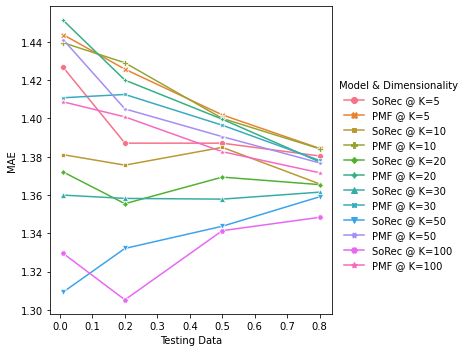

In [ ]:
g = sns.relplot(data=data, x='Testing Data', y='MAE',
                hue='Model & Dimensionality', style='Model & Dimensionality',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "Testing Data", ylabel = "MAE")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('SoRec_2_v2.svg', format='svg', dpi=1200)

## CTR (Collaborative Topic regression)

CTR composes the LDA topic model with matrix factorization to model item (article) texts and user-item preferences

In [ ]:
!cp /content/drive/MyDrive/TempData/srivani_b_recsys/*.svg /content/
!cp /content/drive/MyDrive/TempData/srivani_b_recsys/*.csv /content/

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
movie_df = pd.read_csv('movie_df.csv')
movie_df.head()

movie_id                          movie_name                   tag  \
0         4            Waiting to Exhale (1995)  Comedy Drama Romance   
1         7                      Sabrina (1995)        Comedy Romance   
2         8                 Tom and Huck (1995)    Adventure Children   
3         9                 Sudden Death (1995)                Action   
4        12  Dracula: Dead and Loving It (1995)         Comedy Horror   

                                                text  \
0  Waiting to Exhale (1995) Comedy Drama Romance ...   
1  Sabrina (1995) Comedy Romance While she was gr...   
2  Tom and Huck (1995) Adventure Children Tom Saw...   
3  Sudden Death (1995) Action Darren McCord takes...   
4  Dracula: Dead and Loving It (1995) Comedy Horr...   

                                                plot  
0  This story based on the best selling novel by ...  
1  While she was growing up, Sabrina Fairchild sp...  
2  Tom Sawyer is a mischievous young boy, growing...  
3  Darren McCord takes his two kids to a Pittsbur...  
4  Another spoof from the mind of Mel Brooks . Th...

In [ ]:
# convert to list
docs = movie_df.text.tolist()
item_ids = [str(x) for x in movie_df.movie_id.tolist()]

In [ ]:
rating = pd.read_csv('rating.csv')
rating.head()

user_id  movie_id  rating
0     1076       151     4.5
1     1076       432     2.0
2     1076       529     5.0
3     1076      1233     4.5
4     1076      1234     5.0

In [ ]:
feedback = [tuple(x) for x in rating.to_numpy()]
feedback[:5]

[(1076.0, 151.0, 4.5),
 (1076.0, 432.0, 2.0),
 (1076.0, 529.0, 5.0),
 (1076.0, 1233.0, 4.5),
 (1076.0, 1234.0, 5.0)]

In [ ]:
len(docs), len(item_ids), len(feedback)

(1495, 1495, 3637)

In [ ]:
docs[:5]

["Waiting to Exhale (1995) Comedy Drama Romance This story based on the best selling novel by Terry McMillan follows the lives of four African-American women as they try to deal with their very lives. Friendship becomes the strongest bond between these women as men, careers, and families take them in different directions. Often light-hearted this movie speaks about some of the problems and struggles the modern women face in today's world.",
 "Sabrina (1995) Comedy Romance While she was growing up, Sabrina Fairchild spent more time perched in a tree watching the Larrabee family than she ever did on solid ground. As the chauffeur's daughter on their lavish Long Island estate, Sabrina was invisible behind the branches, but she knew them all below - There is Maude Larrabee, the modern matriarch of the Larrabee Corporation; Linus Larrabee, the serious older son who expanded a successful family business into the world's largest communications company; and David, the handsome, fun-loving Larr

In [ ]:
item_ids[:5]

['4', '7', '8', '9', '12']

In [ ]:
feedback[:5]

[('1076', '151', '4.5'),
 ('1076', '432', '2.0'),
 ('1076', '529', '5.0'),
 ('1076', '1233', '4.5'),
 ('1076', '1234', '5.0')]

In [ ]:
id_encode_map = {k:str(v) for v,k in enumerate(set(item_ids))}

id_encode_map['4']

'1154'

In [ ]:
id_encode_map['7']

'1242'

In [ ]:
item_ids = [id_encode_map[x] for x in item_ids]
item_ids[:5]

['1154', '1242', '94', '40', '395']

In [ ]:
feedback = [(x[0], id_encode_map[x[1]], x[2]) for x in feedback]
feedback[:5]

[('1076', '48', '4.5'),
 ('1076', '369', '2.0'),
 ('1076', '1453', '5.0'),
 ('1076', '784', '4.5'),
 ('1076', '193', '5.0')]

In [ ]:
# Instantiate a TextModality, it makes it convenient to work with text auxiliary information
item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=3000,
    max_doc_freq=0.7,
)

In [ ]:
# Define an evaluation method to split feedback into train and test sets
eval_method = CrossValidation(
    data=feedback,
    n_folds=5,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=True,
    seed=123,
    rating_threshold=3,
)

K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01, 
          verbose=VERBOSE, seed=SEED)

# Use Recall@100 for evaluation
rec_100 = cornac.metrics.Recall(k=100)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=eval_method, models=[wmf, ctr], metrics=[rec_100]).run()

rating_threshold = 3.0
exclude_unknowns = True
Fold: 1
---
Training data:
Number of users = 50
Number of items = 1091
Number of ratings = 2909
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 48
Number of items = 458
Number of ratings = 638
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 48
Number of items = 458
Number of ratings = 638
---
Total users = 50
Total items = 1091

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/48 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 50
Number of items = 1096
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 46
Number of items = 460
Number of ratings = 654
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 46
Number of items = 460
Number of ratings = 654
---
Total users = 50
Total items = 1096

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/46 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 50
Number of items = 1093
Number of ratings = 2909
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 47
Number of items = 449
Number of ratings = 647
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 47
Number of items = 449
Number of ratings = 647
---
Total users = 50
Total items = 1093

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/47 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 50
Number of items = 1084
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 48
Number of items = 465
Number of ratings = 645
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 48
Number of items = 465
Number of ratings = 645
---
Total users = 50
Total items = 1084

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/48 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 50
Number of items = 1079
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 46
Number of items = 462
Number of ratings = 627
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 46
Number of items = 462
Number of ratings = 627
---
Total users = 50
Total items = 1079

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/46 [00:00<?, ?it/s]

Fold: 1
---
Training data:
Number of users = 50
Number of items = 1091
Number of ratings = 2909
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 48
Number of items = 458
Number of ratings = 638
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 48
Number of items = 458
Number of ratings = 638
---
Total users = 50
Total items = 1091

[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/48 [00:00<?, ?it/s]

Fold: 2
---
Training data:
Number of users = 50
Number of items = 1096
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 46
Number of items = 460
Number of ratings = 654
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 46
Number of items = 460
Number of ratings = 654
---
Total users = 50
Total items = 1096

[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/46 [00:00<?, ?it/s]

Fold: 3
---
Training data:
Number of users = 50
Number of items = 1093
Number of ratings = 2909
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 47
Number of items = 449
Number of ratings = 647
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 47
Number of items = 449
Number of ratings = 647
---
Total users = 50
Total items = 1093

[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/47 [00:00<?, ?it/s]

Fold: 4
---
Training data:
Number of users = 50
Number of items = 1084
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 48
Number of items = 465
Number of ratings = 645
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 48
Number of items = 465
Number of ratings = 645
---
Total users = 50
Total items = 1084

[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/48 [00:00<?, ?it/s]

Fold: 5
---
Training data:
Number of users = 50
Number of items = 1079
Number of ratings = 2910
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 46
Number of items = 462
Number of ratings = 627
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 46
Number of items = 462
Number of ratings = 627
---
Total users = 50
Total items = 1079

[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/46 [00:00<?, ?it/s]


TEST:
...
[WMF]
       | Recall@100 | Train (s) | Test (s)
------ + ---------- + --------- + --------
Fold 0 |     0.1829 |    2.1620 |   0.1646
Fold 1 |     0.1925 |    1.4198 |   0.1240
Fold 2 |     0.2277 |    1.4607 |   0.1165
Fold 3 |     0.2326 |    1.4597 |   0.1437
Fold 4 |     0.2155 |    1.4797 |   0.0977
------ + ---------- + --------- + --------
Mean   |     0.2102 |    1.5964 |   0.1293
Std    |     0.0194 |    0.2835 |   0.0230

[CTR]
       | Recall@100 | Train (s) | Test (s)
------ + ---------- + --------- + --------
Fold 0 |     0.2727 |   23.7758 |   0.1200
Fold 1 |     0.2538 |   23.6717 |   0.1471
Fold 2 |     0.2476 |   23.2271 |   0.1396
Fold 3 |     0.2655 |   23.2782 |   0.1385
Fold 4 |     0.2532 |   23.0016 |   0.1096
------ + ---------- + --------- + --------
Mean   |     0.2586 |   23.3909 |   0.1310
Std    |     0.0091 |    0.2892 |   0.0139



In [ ]:
# Instantiate a TextModality, it makes it convenient to work with text auxiliary information
item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=3000,
    max_doc_freq=0.8,
)

# Define an evaluation method to split feedback into train and test sets
eval_method = RatioSplit(
    data=feedback,
    test_size=0.2,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=True,
    seed=123,
    rating_threshold=3,
)

K = 20
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=VERBOSE, seed=SEED)
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.005, lambda_u=0.01, lambda_v=0.01, 
          verbose=VERBOSE, seed=SEED)

# Use Recall@100 for evaluation
rec_100 = cornac.metrics.Recall(k=100)

# Put everything together into an experiment and run it
cornac.Experiment(eval_method=eval_method, models=[wmf, ctr], metrics=[rec_100]).run()

rating_threshold = 3.0
exclude_unknowns = True
---
Training data:
Number of users = 50
Number of items = 1090
Number of ratings = 2909
Max rating = 5.0
Min rating = 0.5
Global mean = 3.5
---
Test data:
Number of users = 49
Number of items = 455
Number of ratings = 640
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 50
Total items = 1090

[WMF] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[WMF] Evaluation started!


Ranking:   0%|          | 0/49 [00:00<?, ?it/s]


[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/49 [00:00<?, ?it/s]


TEST:
...
    | Recall@100 | Train (s) | Test (s)
--- + ---------- + --------- + --------
WMF |     0.1980 |    1.4891 |   0.2277
CTR |     0.2145 |   24.7884 |   0.1188



As CTR is based on topic model, it has intuitive explainability both in terms of model parameters as well as its recommendations. First, we can see what the top words of each topic are, based on learned topic-word distributions :

In [ ]:
vocab = ctr.train_set.item_text.vocab
topic_word_dist = ctr.model.beta.T[:, -ctr.train_set.item_text.max_vocab:] 
top_word_inds = np.argsort(topic_word_dist, axis=1) + 4  # ingore 4 special tokens

topic_words = {}
topic_df = defaultdict(list)
print("WORD TOPICS:")
for t in range(len(topic_word_dist)):
  top_words = vocab.to_text(top_word_inds[t][-10:][::-1], sep=", ")
  topic_words[t+1] = top_words
  topic_df["Topic"].append(t + 1)
  topic_df["Top words"].append(top_words)
topic_df = pd.DataFrame(topic_df)
topic_df

WORD TOPICS:


Topic                                          Top words
0       1  wants, begins, mother, year, scifi, law, gover...
1       2  little, sees, story, dead, lives, thriller, go...
2       3  know, drama, killed, person, want, friends, pl...
3       4  family, make, agent, able, money, let, finally...
4       5  change, work, older, murder, problem, wants, b...
5       6  life, trouble, protect, growing, returns, kill...
6       7  tom, paul, strange, goes, life, soon, private,...
7       8  adventure, home, action, young, little, going,...
8       9  death, wife, children, fantasy, life, deal, le...
9      10  stop, murder, war, comedy, army, living, run, ...
10     11  recently, thriller, love, people, does, daught...
11     12  family, turn, comedy, bank, america, ends, fil...
12     13  mystery, way, pregnant, largely, detective, yo...
13     14  man, new, life, mother, drama, women, help, jo...
14     15  thriller, friend, , day, world, stories, years...
15     16  drama, house, years, time, , working, set, cri...
16     17  harry, local, using, leads, living, going, con...
17     18  woman, action, named, war, comedy, s, romance,...
18     19  comedy, romance, , family, decide, including, ...
19     20  meets, drama, lead, sets, max, girl, , having,...

As item vectors are close to its topic proportions, user vectors can also be used to explain what topics they are interested in.

In [ ]:
UIDX = 23
TOPK = 5

item_id2idx = ctr.train_set.iid_map
item_idx2id = list(ctr.train_set.item_ids)

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 23 TOP-3 TOPICS:


Topic                                          Top words
16     17  harry, local, using, leads, living, going, con...
0       1  wants, begins, mother, year, scifi, law, gover...
9      10  stop, murder, war, comedy, army, living, run, ...

Those are the topics most relevant to user interests. What will be recommendations to this user?

In [ ]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 23:


Description
0  Planes, Trains & Automobiles (1987) Adventure ...
1  Pay It Forward (2000) Children Drama Young Tre...
2  Along Came a Spider (2001) Action Crime Myster...
3  Bio-Dome (1996) Comedy Bud and Doyle are two l...
4  Remember the Titans (2000) Drama Suburban Virg...

Let's check out another user with index = 321. Similarly, we see the top-3 topics this user cares most about:

In [ ]:
UIDX = 4

print(f"USER {UIDX} TOP-3 TOPICS:")
topic_df.loc[np.argsort(ctr.U[UIDX])[-3:][::-1]]

USER 4 TOP-3 TOPICS:


Topic                                          Top words
15     16  drama, house, years, time, , working, set, cri...
6       7  tom, paul, strange, goes, life, soon, private,...
17     18  woman, action, named, war, comedy, s, romance,...

Based on this, how would the model give recommendations to the user?

In [ ]:
recommendations, scores = ctr.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UIDX}:")
rec_df = defaultdict(list)
for i in recommendations[:TOPK]:
  rec_df["Description"].append(ctr.train_set.item_text.corpus[i])
pd.DataFrame(rec_df)


TOP 5 RECOMMENDATIONS FOR USER 4:


Description
0         Royal Tenenbaums, The (2001) Comedy Drama 
1  City of God (Cidade de Deus) (2002) Action Cri...
2     40 Year Old Virgin, The (2005) Comedy Romance 
3  Scarface (1983) Action Crime Drama Tony Montan...
4  Swingers (1996) Comedy Drama This is a story a...

In [ ]:
class CustomExperiment(Experiment):
    def run(self):
        """Run the Cornac experiment"""
        self._create_result()

        for model in self.models:
            test_result, val_result = self.eval_method.evaluate(
                model=model,
                metrics=self.metrics,
                user_based=self.user_based,
                show_validation=self.show_validation,
            )

            self.result.append(test_result)

In [ ]:
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks", {'axes.grid' : False})

rc = {'figure.figsize':(10, 5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Times New Roman',
      'font.size' : 15}
plt.rcParams.update(rc)

In [ ]:
def experiment(row, feedback=None):
    
    VERBOSE = False
    test_size = row.test_size
    K = row.K
    rating_threshold = row.rating_threshold
    learning_rate = row.learning_rate
    user_based = row.user_based
    model = row.model
    lambda_u = row.lambda_u
    lambda_v = row.lambda_v
    sample_size = row.sample_size
    feedback = random.sample(feedback, int(len(feedback)*sample_size))

    # Instantiate a TextModality, it makes it convenient to work with text auxiliary information
    item_text_modality = TextModality(
        corpus=docs,
        ids=item_ids,
        tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
        max_vocab=3000,
        max_doc_freq=0.8,
    )

    # Use Recall@100 for evaluation
    rec_100 = cornac.metrics.Recall(k=100)

    ratio_split = RatioSplit(
        data=feedback,
        test_size=test_size,
        exclude_unknowns=True,
        item_text=item_text_modality,
        verbose=VERBOSE,
        seed=SEED,
        rating_threshold=rating_threshold,
    )

    if model == 'ctr':
        model = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=lambda_u, lambda_v=lambda_v, verbose=VERBOSE, seed=SEED)
    elif model == 'wmf':
        model = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=learning_rate, lambda_u=lambda_u, lambda_v=lambda_v, verbose=VERBOSE, seed=SEED)

    exp = CustomExperiment(eval_method=ratio_split, models=[model], metrics=[rec_100], user_based=user_based,
                     verbose=VERBOSE, save_dir=None)
    _ = exp.run()

    # return exp

    row = row.append(pd.Series(dict(exp.result[0].metric_avg_results)))

    return row

### Exp 1

In [ ]:
# grid
test_size = [0.2]
K = [20]
rating_threshold = [3]
learning_rate = [0.001]
lambda_u = [0.01]
lambda_v = [0.01]
sample_size = [1, 0.8, 0.5, 0.2, 0.1]
user_based = [True]
model = ['ctr','wmf']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_u, lambda_v,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_u',
                                'lambda_v',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      0.01   
3        0.2  20                 3          0.001      0.01      0.01   
4        0.2  20                 3          0.001      0.01      0.01   
5        0.2  20                 3          0.001      0.01      0.01   
6        0.2  20                 3          0.001      0.01      0.01   
7        0.2  20                 3          0.001      0.01      0.01   
8        0.2  20                 3          0.001      0.01      0.01   
9        0.2  20                 3          0.001      0.01      0.01   

   user_based model  sample_size  
0        True   ctr          1.0  
1        True   ctr          0.8  
2        True   ctr          0.5  
3        True   ctr          0.2  
4        True   ctr          0.1  
5        True   wmf          1.0  
6        True   wmf          0.8  
7        True   wmf          0.5  
8        True   wmf          0.2  
9        True   wmf          0.1

In [ ]:
results1 = params.progress_apply(experiment, feedback=feedback, axis=1)
results1.head()

  0%|          | 0/10 [00:00<?, ?it/s]

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      0.01   
3        0.2  20                 3          0.001      0.01      0.01   
4        0.2  20                 3          0.001      0.01      0.01   

   user_based model  sample_size  Recall@100  Train (s)  Test (s)  
0        True   ctr          1.0    0.172446  23.420131  0.026332  
1        True   ctr          0.8    0.152881  22.075119  0.023532  
2        True   ctr          0.5    0.197747  19.588452  0.027579  
3        True   ctr          0.2    0.258095  11.460814  0.011217  
4        True   ctr          0.1    0.500000   6.670570  0.003814

In [ ]:
data = results1[['sample_size', 'model', 'Recall@100']]
data['model'] = data['model'].replace({'ctr':'CTR', 'wmf':'WMF'})
data = data.rename(columns={'model':'Model', 'sample_size':'Training size'})
data

Training size Model  Recall@100
0            1.0   CTR    0.172446
1            0.8   CTR    0.152881
2            0.5   CTR    0.197747
3            0.2   CTR    0.258095
4            0.1   CTR    0.500000
5            1.0   WMF    0.141230
6            0.8   WMF    0.048423
7            0.5   WMF    0.112322
8            0.2   WMF    0.222222
9            0.1   WMF    0.171429

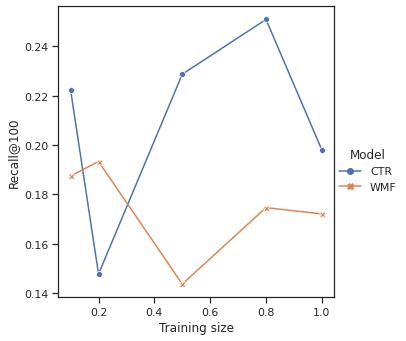

In [ ]:
g = sns.relplot(data=data, x='Training size', y='Recall@100',
                hue='Model', style='Model',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "Training size", ylabel = "Recall@100")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('CTR_3_v2.svg', format='svg', dpi=1200)

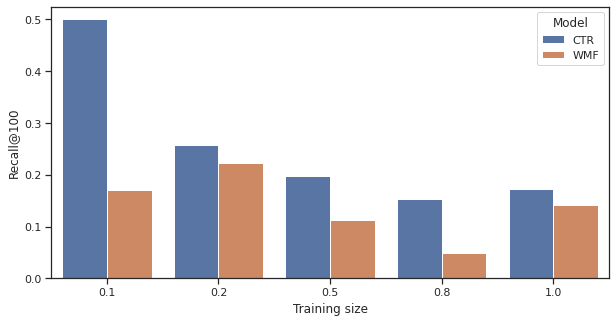

In [ ]:
g = sns.barplot(data=data, x='Training size', y='Recall@100', hue='Model')
plt.show()

In [ ]:
g.figure.savefig('CTR_3_v2_bar.svg', format='svg', dpi=1200)

### Exp 2

In [ ]:
test_size = [0.2]
K = [10, 20, 40, 60, 100, 150, 200]
rating_threshold = [3]
learning_rate = [0.001]
lambda_u = [0.01]
lambda_v = [0.01]
sample_size = [1]
user_based = [True]
model = ['ctr','wmf']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_u, lambda_v,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_u',
                                'lambda_v',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size    K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0         0.2   10                 3          0.001      0.01      0.01   
1         0.2   10                 3          0.001      0.01      0.01   
2         0.2   20                 3          0.001      0.01      0.01   
3         0.2   20                 3          0.001      0.01      0.01   
4         0.2   40                 3          0.001      0.01      0.01   
5         0.2   40                 3          0.001      0.01      0.01   
6         0.2   60                 3          0.001      0.01      0.01   
7         0.2   60                 3          0.001      0.01      0.01   
8         0.2  100                 3          0.001      0.01      0.01   
9         0.2  100                 3          0.001      0.01      0.01   
10        0.2  150                 3          0.001      0.01      0.01   
11        0.2  150                 3          0.001      0.01      0.01   
12        0.2  200                 3          0.001      0.01      0.01   
13        0.2  200                 3          0.001      0.01      0.01   

    user_based model  sample_size  
0         True   ctr            1  
1         True   wmf            1  
2         True   ctr            1  
3         True   wmf            1  
4         True   ctr            1  
5         True   wmf            1  
6         True   ctr            1  
7         True   wmf            1  
8         True   ctr            1  
9         True   wmf            1  
10        True   ctr            1  
11        True   wmf            1  
12        True   ctr            1  
13        True   wmf            1

In [ ]:
results2 = params.progress_apply(experiment, feedback=feedback, axis=1)
results2.head()

  0%|          | 0/14 [00:00<?, ?it/s]

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  10                 3          0.001      0.01      0.01   
1        0.2  10                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      0.01   
3        0.2  20                 3          0.001      0.01      0.01   
4        0.2  40                 3          0.001      0.01      0.01   

   user_based model  sample_size  Recall@100  Train (s)  Test (s)  
0        True   ctr            1    0.208561  20.136525  0.028264  
1        True   wmf            1    0.171012   0.878966  0.027874  
2        True   ctr            1    0.218272  36.124102  0.031992  
3        True   wmf            1    0.121239   1.568598  0.070721  
4        True   ctr            1    0.133254  27.753434  0.027289

In [ ]:
data = results2[['K', 'model', 'Recall@100']]
data['model'] = data['model'].replace({'ctr':'CTR', 'wmf':'WMF'})
data = data.rename(columns={'model':'Model',
                            'K':'Dimensionality'})
data

Dimensionality Model  Recall@100
0               10   CTR    0.208561
1               10   WMF    0.171012
2               20   CTR    0.218272
3               20   WMF    0.121239
4               40   CTR    0.133254
5               40   WMF    0.160018
6               60   CTR    0.101448
7               60   WMF    0.150217
8              100   CTR    0.095294
9              100   WMF    0.233385
10             150   CTR    0.150045
11             150   WMF    0.264953
12             200   CTR    0.097245
13             200   WMF    0.181859

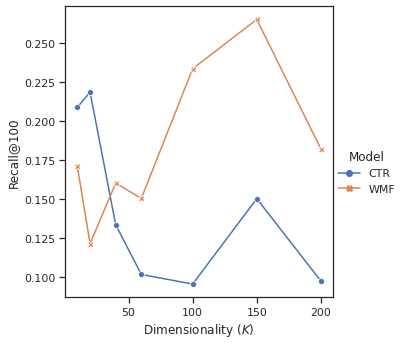

In [ ]:
g = sns.relplot(data=data, x='Dimensionality', y='Recall@100',
                hue='Model', style='Model',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "Dimensionality ($K$)", ylabel = "Recall@100")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('CTR_2_v3.svg', format='svg', dpi=1200)

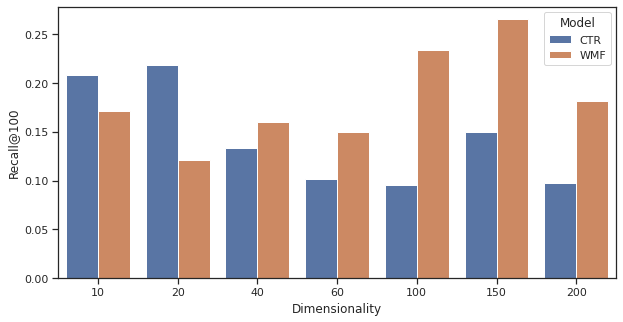

In [ ]:
g = sns.barplot(data=data, x='Dimensionality', y='Recall@100', hue='Model')
plt.show()

In [ ]:
g.figure.savefig('CTR_2_v3_bar.svg', format='svg', dpi=1200)

### Exp3

In [ ]:
test_size = [0.2]
K = [20]
rating_threshold = [3]
learning_rate = [0.001]
lambda_u = [0.01, 0.1, 0.03, 0.5, 1]
lambda_v = [0.01]
sample_size = [1]
user_based = [True]
model = ['ctr','wmf']


params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_u, lambda_v,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_u',
                                'lambda_v',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.10      0.01   
3        0.2  20                 3          0.001      0.10      0.01   
4        0.2  20                 3          0.001      0.03      0.01   
5        0.2  20                 3          0.001      0.03      0.01   
6        0.2  20                 3          0.001      0.50      0.01   
7        0.2  20                 3          0.001      0.50      0.01   
8        0.2  20                 3          0.001      1.00      0.01   
9        0.2  20                 3          0.001      1.00      0.01   

   user_based model  sample_size  
0        True   ctr            1  
1        True   wmf            1  
2        True   ctr            1  
3        True   wmf            1  
4        True   ctr            1  
5        True   wmf            1  
6        True   ctr            1  
7        True   wmf            1  
8        True   ctr            1  
9        True   wmf            1

In [ ]:
results3 = params.progress_apply(experiment, feedback=feedback, axis=1)
results3.head()

  0%|          | 0/10 [00:00<?, ?it/s]

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.10      0.01   
3        0.2  20                 3          0.001      0.10      0.01   
4        0.2  20                 3          0.001      0.03      0.01   

   user_based model  sample_size  Recall@100  Train (s)  Test (s)  
0        True   ctr            1    0.182168  24.242162  0.025340  
1        True   wmf            1    0.073421   0.898317  0.026844  
2        True   ctr            1    0.263812  23.945540  0.026819  
3        True   wmf            1    0.120422   0.877919  0.047015  
4        True   ctr            1    0.171249  23.744515  0.033659

In [ ]:
data = results3[['lambda_u', 'model', 'Recall@100']]
data['model'] = data['model'].replace({'ctr':'CTR', 'wmf':'WMF'})
data = data.rename(columns={'model':'Model'})
data

lambda_u Model  Recall@100
0      0.01   CTR    0.182168
1      0.01   WMF    0.073421
2      0.10   CTR    0.263812
3      0.10   WMF    0.120422
4      0.03   CTR    0.171249
5      0.03   WMF    0.157299
6      0.50   CTR    0.193509
7      0.50   WMF    0.141842
8      1.00   CTR    0.217809
9      1.00   WMF    0.127951

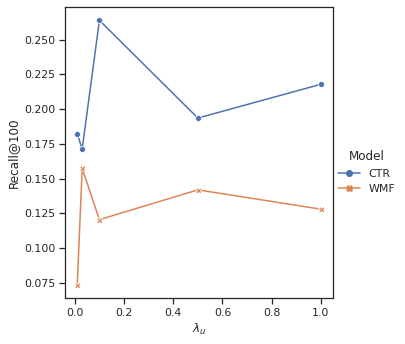

In [ ]:
g = sns.relplot(data=data, x='lambda_u', y='Recall@100',
                hue='Model', style='Model',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "$\lambda_u$", ylabel = "Recall@100")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('CTR_3_v3.svg', format='svg', dpi=1200, bbox_inches="tight")

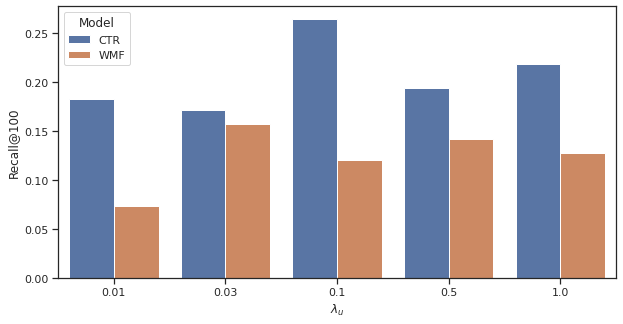

In [ ]:
g = sns.barplot(data=data, x='lambda_u', y='Recall@100', hue='Model')
g.set(xlabel = "$\lambda_u$")
plt.show()

In [ ]:
g.figure.savefig('CTR_3_v3_bar.svg', format='svg', dpi=1200)

### Exp4

In [ ]:
test_size = [0.2]
K = [20]
rating_threshold = [3]
learning_rate = [0.001]
lambda_u = [0.01]
lambda_v = [0.01, 0.1, 0.03, 0.5, 1]
sample_size = [1]
user_based = [True]
model = ['ctr','wmf']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_u, lambda_v,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_u',
                                'lambda_v',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      0.10   
3        0.2  20                 3          0.001      0.01      0.10   
4        0.2  20                 3          0.001      0.01      0.03   
5        0.2  20                 3          0.001      0.01      0.03   
6        0.2  20                 3          0.001      0.01      0.50   
7        0.2  20                 3          0.001      0.01      0.50   
8        0.2  20                 3          0.001      0.01      1.00   
9        0.2  20                 3          0.001      0.01      1.00   

   user_based model  sample_size  
0        True   ctr            1  
1        True   wmf            1  
2        True   ctr            1  
3        True   wmf            1  
4        True   ctr            1  
5        True   wmf            1  
6        True   ctr            1  
7        True   wmf            1  
8        True   ctr            1  
9        True   wmf            1

In [ ]:
results4 = params.progress_apply(experiment, feedback=feedback, axis=1)
results4.head()

  0%|          | 0/10 [00:00<?, ?it/s]

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      0.10   
3        0.2  20                 3          0.001      0.01      0.10   
4        0.2  20                 3          0.001      0.01      0.03   

   user_based model  sample_size  Recall@100  Train (s)  Test (s)  
0        True   ctr            1    0.219932  44.178927  0.032376  
1        True   wmf            1    0.139914   1.164938  0.069948  
2        True   ctr            1    0.261905  31.206545  0.062567  
3        True   wmf            1    0.151984   1.491287  0.049237  
4        True   ctr            1    0.238425  29.075406  0.027120

In [ ]:
data = results4[['lambda_v', 'model', 'Recall@100']]
data['model'] = data['model'].replace({'ctr':'CTR', 'wmf':'WMF'})
data = data.rename(columns={'model':'Model'})
data

lambda_v Model  Recall@100
0      0.01   CTR    0.219932
1      0.01   WMF    0.139914
2      0.10   CTR    0.261905
3      0.10   WMF    0.151984
4      0.03   CTR    0.238425
5      0.03   WMF    0.126054
6      0.50   CTR    0.165633
7      0.50   WMF    0.134905
8      1.00   CTR    0.154653
9      1.00   WMF    0.132554

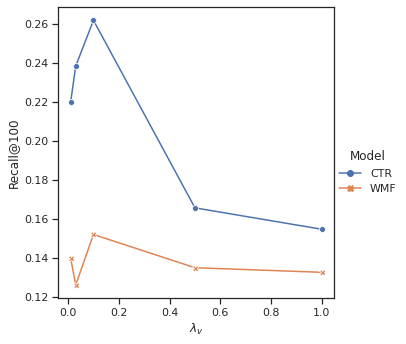

In [ ]:
g = sns.relplot(data=data, x='lambda_v', y='Recall@100',
                hue='Model', style='Model',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "$\lambda_v$", ylabel = "Recall@100")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('CTR_4_v3.svg', format='svg', dpi=1200, bbox_inches="tight")

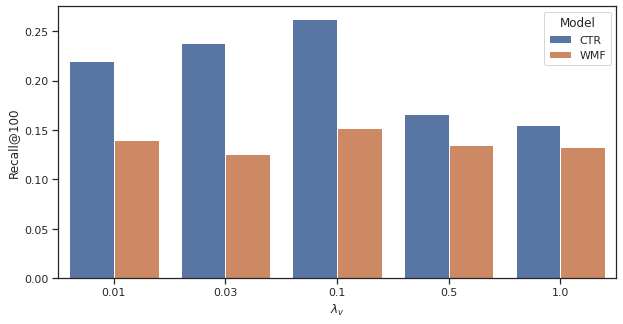

In [ ]:
g = sns.barplot(data=data, x='lambda_v', y='Recall@100', hue='Model')
g.set(xlabel = "$\lambda_v$")
plt.show()

In [ ]:
g.figure.savefig('CTR_4_v3_bar.svg', format='svg', dpi=1200)

### Exp5

In [ ]:
test_size = [0.2]
K = [20]
rating_threshold = [3]
learning_rate = [0.001]
lambda_u = [0.01]
lambda_v = [0.01, 1, 10, 100, 1000]
sample_size = [1]
user_based = [True]
model = ['ctr','wmf']

params = pd.DataFrame(list(product(test_size, K, rating_threshold,
                          learning_rate, lambda_u, lambda_v,
                          user_based, model, sample_size)),
                        columns=['test_size', 'K',
                                'rating_threshold',
                                'learning_rate',
                                'lambda_u',
                                'lambda_v',
                                 'user_based',
                                 'model',
                                 'sample_size'])

params

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      1.00   
3        0.2  20                 3          0.001      0.01      1.00   
4        0.2  20                 3          0.001      0.01     10.00   
5        0.2  20                 3          0.001      0.01     10.00   
6        0.2  20                 3          0.001      0.01    100.00   
7        0.2  20                 3          0.001      0.01    100.00   
8        0.2  20                 3          0.001      0.01   1000.00   
9        0.2  20                 3          0.001      0.01   1000.00   

   user_based model  sample_size  
0        True   ctr            1  
1        True   wmf            1  
2        True   ctr            1  
3        True   wmf            1  
4        True   ctr            1  
5        True   wmf            1  
6        True   ctr            1  
7        True   wmf            1  
8        True   ctr            1  
9        True   wmf            1

In [ ]:
results5 = params.progress_apply(experiment, feedback=feedback, axis=1)
results5.head()

  0%|          | 0/10 [00:00<?, ?it/s]

test_size   K  rating_threshold  learning_rate  lambda_u  lambda_v  \
0        0.2  20                 3          0.001      0.01      0.01   
1        0.2  20                 3          0.001      0.01      0.01   
2        0.2  20                 3          0.001      0.01      1.00   
3        0.2  20                 3          0.001      0.01      1.00   
4        0.2  20                 3          0.001      0.01     10.00   

   user_based model  sample_size  Recall@100  Train (s)  Test (s)  
0        True   ctr            1    0.197886  26.705174  0.025478  
1        True   wmf            1    0.151193   0.874913  0.028851  
2        True   ctr            1    0.235887  24.562861  0.027126  
3        True   wmf            1    0.110169   0.905577  0.028558  
4        True   ctr            1    0.127965  23.561939  0.024769

In [ ]:
data = results5[['lambda_v', 'model', 'Recall@100']]
data['model'] = data['model'].replace({'ctr':'CTR', 'wmf':'WMF'})
data = data.rename(columns={'model':'Model'})
data

lambda_v Model  Recall@100
0      0.01   CTR    0.197886
1      0.01   WMF    0.151193
2      1.00   CTR    0.235887
3      1.00   WMF    0.110169
4     10.00   CTR    0.127965
5     10.00   WMF    0.103746
6    100.00   CTR    0.155685
7    100.00   WMF    0.193663
8   1000.00   CTR    0.089956
9   1000.00   WMF    0.083309

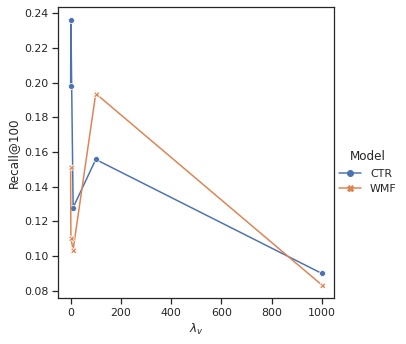

In [ ]:
g = sns.relplot(data=data, x='lambda_v', y='Recall@100',
                hue='Model', style='Model',
                markers=True, dashes=False,
                kind='line')
g.set(xlabel = "$\lambda_v$", ylabel = "Recall@100")
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

In [ ]:
g.figure.savefig('CTR_5_v3.svg', format='svg', dpi=1200, bbox_inches="tight")

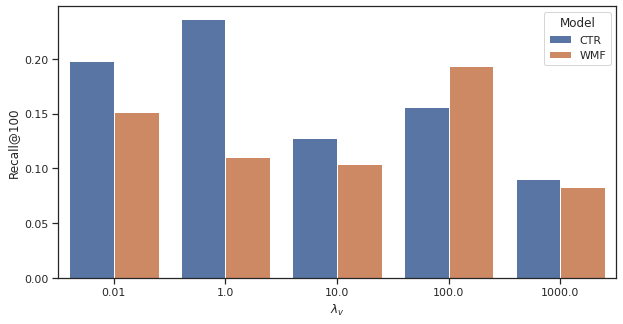

In [ ]:
g = sns.barplot(data=data, x='lambda_v', y='Recall@100', hue='Model')
g.set(xlabel = "$\lambda_v$")
plt.show()

In [ ]:
g.figure.savefig('CTR_5_v3_bar.svg', format='svg', dpi=1200)

---

In [ ]:
!cp /content/*.svg /content/drive/MyDrive/TempData/srivani_b_recsys
!cp /content/*.csv /content/drive/MyDrive/TempData/srivani_b_recsys

*End*